# Load stuff

In [34]:
import pandas as pd
import numpy as np
import re
import string
import time
from bs4 import BeautifulSoup
import spacy
nlp = spacy.load('en_core_web_sm')
from scipy.sparse import csr_matrix
import scipy.sparse as sps
import matplotlib.pyplot as plt
!pip install leidenalg # this is the Louvain version we use!!!!
import leidenalg
import igraph as ig
import pickle
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.cm
!pip install umap-learn
import umap
import seaborn as sns

In [35]:
!pip install bertopic
from bertopic import BERTopic

In [36]:
!pip install datamapplot
import datamapplot

In [37]:
def logg(x):
    y = np.log(x)
    y[x==0] = 0
    return y

def nmi_fn(A): # A = Pwc
    aw = A.sum(axis=1).flatten() # word probability
    ac = A.sum(axis=0).flatten() # class probability
    Hc = np.multiply(ac,-logg(ac)).sum() # class entropy
    A2 = ((A/ac).T/aw).T
    A2.data = logg(A2.data)
    y = (A.multiply(A2)).sum()/Hc
    return y

def modularity_fn(A):
    y = A.trace()-(A.sum(axis=0)*A.sum(axis=1)).item()
    return y

def ncut_fn(A):
    y = ((A.sum(axis=0)-A.diagonal())/A.sum(axis=0)).mean()
    return y

def pagerank_fn(M,q,c=.85,it=60):
    r = q.copy() # ranking matrix, initialized to q (copy)
    for k in range(it): # slow cycle
      r = c*M.dot(r) + (1-c)*q
    return r

def _infomap_fn(v):
    y = -(v.data*logg(v.data/v.sum())).sum()
    return y

def infomap_rank_fn(Pdd):
    # transition matrix
    pd = Pdd.sum(axis=0).flatten()
    M = sps.csr_matrix(Pdd/pd)
    # pagerank vector - faster than r = pagerank_fn(M,q)
    G = ig.Graph.Adjacency((M > 0).toarray().tolist())
    G.es['weight'] = np.array(M[M.nonzero()])[0]
    r = G.pagerank(weights='weight')
    r = (sps.csr_matrix(np.array(r))).T
    return r

def infomap_fn(C,Pdd,r):
    pd = Pdd.sum(axis=0).flatten()
    M = Pdd/pd # transition matrix
    # extract vectors
    z = (C.T).dot(sps.diags(r.toarray().flatten()))
    q = sps.csr_matrix((1,z.shape[0]))
    c = .85
    for i in range(z.shape[0]):
      tmp = ((C[:,i].transpose()).dot(M)).dot(z[i].transpose())
      q[0,i] = (1-(1-c)*C[:,i].sum()/M.shape[0])*z[i].sum()-c*tmp[0,0]
    # extract statistics
    y = _infomap_fn(q)
    for i in range(z.shape[0]):
      y += _infomap_fn(sps.hstack([z[i],sps.csr_matrix([[q[0,i]]])]))
    # normalize
    y = (y/_infomap_fn(pd))-1
    return y

def _hlstr(string: str , color: str = 'white'):
    # return f"<mark style=background-color:{color}>{string} </mark>"
    return f"<span style=\"color:{color}\">{string} </span>"

def _colorize(attrs: np.ndarray, cmap: str = 'PiYG'):
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    cmap = matplotlib.colormaps.get_cmap(cmap)
    return list(map(lambda x: mpl.colors.rgb2hex(cmap(norm(x))), attrs))

def _display_html(tokens, attrs, co=1):
    return HTML("".join(list(map(_hlstr, tokens, _colorize(co*attrs)))))

def get_words_html(vec,wor,N):
    ind = np.argsort(-vec)
    wor = wor[ind[:N]]
    vec = vec[ind[:N]]
    vec = vec/vec[0]
    for j in range(len(wor)):
        wor[j] = str(nlp(str(wor[j]))[0].lemma_)
    return _display_html(wor,vec).data

In [38]:
class TopicDetection:
    # builds an occurrence matrix for words
    def __init__(self, ct_class=[], n_min=2, n_max=1e10):
      if ct_class:
        # capture execution time
        tic = time.time()
        # collection of words
        self.words = np.unique([item for sublist in ct_class.pos_clean for item in sublist])
        # words dictionary
        words_dict = dict(zip(self.words,range(len(self.words))))
        # occurrence matrix for words
        self.Mwd = csr_matrix((len(self.words), len(ct_class.text)), dtype = np.int8).toarray()
        for i in range(len(ct_class.text)):
            for j in ct_class.pos_clean[i]:
                self.Mwd[words_dict[j],i] += 1
        # documents list
        self.documents = np.array(range(len(ct_class.text)))
        # remove words that are used once or twice
        select = ((np.sum(self.Mwd,axis=1)>=n_min)&(np.sum(self.Mwd,axis=1)<n_max))
        print('removing words...')
        with np.printoptions(threshold=np.inf):
          print(self.words[(np.sum(self.Mwd,axis=1)>=n_max)])
        self.Mwd = self.Mwd[select,:]
        self.words = self.words[select]
        # remove documents that do not contain words
        select = (np.sum(self.Mwd,axis=0)>0)
        self.Mwd = csr_matrix(self.Mwd[:,select])
        self.documents = self.documents[select]
        # capture execution time
        print(f'Occurrence matrix: execution time {time.time()-tic} [s]')

    # plots words occurrencies
    def plot_word_occurrence(self):
        plt.figure(figsize=(4, 3))
        plt.semilogy(-np.sort(-np.asarray(np.sum(td1.Mwd,axis=1)).reshape(-1)))
        plt.grid(True)
        plt.xlabel('word id')
        plt.ylabel('# of occurrences')
        plt.title("words occurrencies")

    # plots degree distributions
    def plot_degree_distributions(self,quale='words'):
        if quale=='words':
            dw = np.squeeze(np.asarray(self.Mwd.sum(axis=1))) # words degrees
        else:
            dw = np.squeeze(np.asarray(self.Mwd.sum(axis=0))) # documents degrees
        # degree distribution
        k = np.unique(dw)
        pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
        pk = pk/pk.sum()
        Pk = 1-np.cumsum(pk)
        # plot
        fig = plt.figure(figsize=(4, 3))
        plt.loglog(k,pk,'o')
        if quale=='words':
            plt.title("degree distribution for words")
        else:
            plt.title("degree distribution for documents")
        plt.xlabel("k")
        plt.ylabel("pk")
        plt.grid(True)
        plt.show()

    # build probability matrices
    def probability_matrices(self, equalik = True, tform = False):
        # capture execution time
        tic = time.time()
        if equalik: # documents equally likely
            self.Pwd = self.Mwd/self.Mwd.sum(axis=0).flatten()/self.Mwd.shape[1]
        else: # documents proportional to their length
            self.Pwd = self.Mwd/self.Mwd.sum()
        # TF-IDF format
        if (tform):
            iw = -logg(np.sum(self.Mwd>0,axis=1).flatten()/self.Mwd.shape[1])
            self.Pwd = sps.diags(np.array(iw)[0]).dot(self.Pwd) # TF-IDF form
            self.Pwd = self.Pwd/self.Pwd.sum() # normalize, treat it as Pwd
        # words and document matrices
        self.pd = self.Pwd.sum(axis=0).flatten()
        self.Pww = (self.Pwd/self.pd).dot(self.Pwd.T)
        self.pw = self.Pwd.sum(axis=1).flatten()
        self.Pdd = (self.Pwd.T/self.pw).dot(self.Pwd)
        # # joint words and document matrix - documents first
        # self.Paa = sps.hstack((sps.csr_matrix((self.Pwd.shape[1],self.Pwd.shape[1])),self.Pwd.T))
        # self.Paa = sps.vstack((self.Paa,sps.hstack((self.Pwd,sps.csr_matrix((self.Pwd.shape[0],self.Pwd.shape[0]))))))
        # self.Paa = self.Paa/2.0
        # ranking vector for Infomap
        self.rd = infomap_rank_fn(self.Pdd)
        # capture execution time
        print(f'Probability matrices: execution time {time.time()-tic} [s]')

    # run topic detection using Louvain
    def topic_detection_louvain(self):
        # capture execution time
        tic = time.time()

        # build a graph based on Pdd as adjacency matrix
        A = sps.csr_matrix(self.Pdd)
        G = ig.Graph.Adjacency((A > 0).toarray().tolist())
        G.es['weight'] = np.array(A[A.nonzero()])[0]
        # run Louvain on the graph to get a partition
        self.topics = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition,
                                        weights='weight')
        # map the partition into a community assignment matrix C
        self.C = self._partition_to_C()
        self.topics = [np.argmax(i) for i in self.C] # turn C into a vector!
        # updates topic matrices
        self.Pwc = self.Pwd.dot(self.C) # joint word + class probability
        self.Pcc = ((self.C.T).dot(self.Pdd)).dot(self.C) # joint class + class probability
        self.pc = self.Pcc.sum(axis=0)

        # capture execution time
        ext = time.time()-tic
        print(f'Louvain topic detection: execution time {ext} [s]')
        return ext

    # function to map the partition into a community assignment matrix C
    # where rows represent documents, and columns represent topics
    def _partition_to_C(self):
      C = sps.csr_matrix((self.Pdd.shape[0],len(self.topics)))
      for i in range(len(self.topics)):
        C[np.array(self.topics[i]),i] = 1
      return C

    # display clustering metrics
    def clustering_metrics(self, ext=np.inf):
        NMI = nmi_fn(self.Pwc)
        Q = modularity_fn(self.Pcc)
        Ncut = ncut_fn(self.Pcc)
        Infomap = infomap_fn(self.C,self.Pdd,self.rd)
        if (self.pc.shape[1]==1):
            com = 0
        else:
            com = _infomap_fn(self.pc)/np.log(self.pc.shape[1])
        if ext==np.inf:
          self.stats = {'topics': self.C.shape[1], 'com': com,
                        'NMI': NMI, 'Q': Q, 'Ncut': Ncut, 'Infomap': Infomap}
        else:
          self.stats = {'topics': self.C.shape[1], 'com': com, 'time': ext,
                        'NMI': NMI, 'Q': Q, 'Ncut': Ncut, 'Infomap': Infomap}

    # display clusters
    def display_clusters(self):
        # ordered cluster matrix
        pos = np.argsort(np.array([np.argmax(i) for i in self.C]))
        C = sps.csr_matrix(self.C.copy()).astype(np.float32)
        C = C[pos,]
        M = C*(C.T) # binary matrix with ones inside the communities
        # plot
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
        ax[0].plot(np.array(self.C.sum(axis=0))[0]/self.C.sum(),'o')
        ax[0].set_title('clusters dimensions')
        ax[0].grid(True)
        ax[1].imshow(M.toarray(), cmap='viridis')
        ax[1].set_xticklabels([])
        ax[1].set_yticklabels([])
        ax[1].set_title('clusters patterns')

    # display keywords
    def display_keywords(self, text, N=15):
      # build HTML array according to the weights in Pwc
      x = []
      for i in range(self.Pwc.shape[1]):
        x.append([get_words_html(self.Pwc.T[i].toarray()[0],self.words,N)])
      # build HTML array according to TF-IDF weigts in BERTopic
      topic_model = BERTopic() # prepare a BERTopic instance
      topic_model.fit(text)
      topic_model.update_topics(text, topics=self.topics, top_n_words=N)
      bx = [] #
      for k in range(self.C.shape[1]):
        wor = np.array([i for (i,j) in topic_model.get_topic(k)])
        vec = np.array([j for (i,j) in topic_model.get_topic(k)])
        bx.append([get_words_html(vec,wor,N)])
      # join them together and add titles
      c = np.concatenate(([[f'{i}'] for i in range(self.C.shape[1])],
                          [[f'{int(i)}'] for i in np.array(self.C.sum(axis=0))[0]],
                          np.array(x),np.array(bx)), axis=1)
      c = np.concatenate(([['Topic','#docs','Probability matrices keywords',
                                    'BERTopic keywords']],c))
      # map into HTML table and print
      out = '<table><col><col><col width=\"250\"><col width=\"250\">'
      out = out + ''
      for sublist in c:
          out = out + ' <tr><td style=\"padding:1px 8px;\" valign=\"top\">'
          out = out + ' </td><td style=\"padding:1px 8px;\" valign=\"top\">'.join(sublist)
          out = out + ' </td></tr>'
      out = out + ' </table>'
      display(HTML(out))

    # export data
    def pickle_export(self, filename):
        out_data = {
            'words': self.words,
            'documents': self.documents,
            'Mwd': self.Mwd,
            'Pwd': self.Pwd,
            'Pww': self.Pww,
            'Pdd': self.Pdd,
            'pd': self.pd,
            'pw': self.pw,
            'rd': self.rd,
            'Pwc': self.Pwc,
            'Pcc': self.Pcc,
            'pc': self.pc,
            'Pwc': self.Pwc,
            'Pcc': self.Pcc,
            'pc': self.pc,
            'C': self.C,
            'topics': self.topics,
            'stats': self.stats
        }
        with open(filename, 'wb') as f:
            pickle.dump(out_data, f)

    # import data
    def pickle_import(self, filename):
        with open(filename, 'rb') as f:
            in_data = pickle.load(f)
        self.words = in_data['words']
        self.documents = in_data['documents']
        self.Mwd = in_data['Mwd']
        self.Pwd = in_data['Pwd']
        self.Pww = in_data['Pww']
        self.Pdd = in_data['Pdd']
        self.pd = in_data['pd']
        self.pw = in_data['pw']
        self.rd = in_data['rd']
        self.Pwc = in_data['Pwc']
        self.Pcc = in_data['Pcc']
        self.pc = in_data['pc']
        self.Pwc = in_data['Pwc']
        self.Pcc = in_data['Pcc']
        self.pc = in_data['pc']
        self.C = in_data['C']
        self.topics = in_data['topics']
        self.stats = in_data['stats']

# Load data

In [39]:
# load dataframe
df = pd.read_excel("Lab2_data.xlsx")
df.head()

id_text                                               text
0        0  while parking at a doctors office, i pulled in...
1        0  Once i had parked i reied to say sorry as i co...
2        0  It was after all a genuine mistake on my park ...
3        0  but this person was in such a foul mood i coul...
4        1                   My friend told me I am an idiot.

# BERTopic

In [40]:
topic_model = BERTopic(nr_topics="auto")
docs = df['text']
topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

Topic  Count                                    Name  \
0      -1   1240                        -1_the_to_and_me   
1       0    324                        0_she_her_me_and   
2       1    268                    1_feel_felt_and_very   
3       2    230                         2_he_him_me_and   
4       3    128                      3_bus_the_car_road   
5       4     99                 4_friends_with_bar_were   
6       5     64                     5_driver_car_the_me   
7       6     63     6_friend_with_relationship_argument   
8       7     38           7_didn_nothing_result_surprjs   
9       8     34             8_customer_item_the_receipt   
10      9     33         9_patient_doctor_hospital_visit   
11     10     32  10_line_supermarket_customer_customers   
12     11     24               11_sexist_insult_as_would   
13     12     22        12_working_waitress_job_clothing   
14     13     21                13_happened_ago_it_never   
15     14     21               14_slut_called_slag_names   
16     15     20                   15_man_he_me_suddenly   
17     16     20       16_sorry_apologise_apologized_but   
18     17     20              17_talking_am_thesis_about   
19     18     19              18_try_take_little_anymore   
20     19     19            19_teacher_test_teachers_the   
21     20     18                20_street_walking_own_am   
22     21     17               21_calm_not_situation_try   
23     22     15            22_gentleman_tray_plate_asks   
24     23     14             23_parking_space_car_pulled   
25     24     13                 24_it_winter_dark_night   
26     25     13                 25_my_sister_starts_cry   
27     26     12                    26_16_boys_was_group   

                                       Representation  \
0       [the, to, and, me, was, he, my, in, that, of]   
1   [she, her, me, and, to, that, they, the, my, c...   
2   [feel, felt, and, very, because, it, scared, s...   
3   [he, him, me, and, to, that, his, with, starte...   
4   [bus, the, car, road, on, traffic, stop, drivi...   
5   [friends, with, bar, were, my, out, we, of, th...   
6   [driver, car, the, me, window, and, at, behind...   
7   [friend, with, relationship, argument, boyfrie...   
8   [didn, nothing, result, surprjs, ha, facts, pa...   
9   [customer, item, the, receipt, refund, shop, p...   
10  [patient, doctor, hospital, visit, nurse, bloo...   
11  [line, supermarket, customer, customers, the, ...   
12  [sexist, insult, as, would, women, it, people,...   
13  [working, waitress, job, clothing, am, hotel, ...   
14  [happened, ago, it, never, experience, this, y...   
15  [slut, called, slag, names, attention, guy, na...   
16  [man, he, me, suddenly, rush, crossed, the, st...   
17  [sorry, apologise, apologized, but, say, we, w...   
18  [talking, am, thesis, about, subject, desk, un...   
19  [try, take, little, anymore, no, leaving, enou...   
20  [teacher, test, teachers, the, classroom, day,...   
21  [street, walking, own, am, busy, on, business,...   
22  [calm, not, situation, try, but, to, was, as, ...   
23  [gentleman, tray, plate, asks, he, take, him, ...   
24  [parking, space, car, pulled, unload, looking,...   
25  [it, winter, dark, night, was, evening, ago, i...   
26  [my, sister, starts, cry, brother, grandmother...   
27  [16, boys, was, group, age, time, first, young...   

                                  Representative_Docs  
0   [I was very upset and this was not normally th...  
1   [When she did finally address me, she just sai...  
2   [and I feel very bad about it., I felt attacke...  
3   [He started to say he had something to tell me...  
4   [The bus then pulled up to the bus stop., I wa...  
5   [It was on a day out with my friends., I was o...  
6   [We were in the middle of crossing the road an...  
7   [I'm talking to my ex-boyfriend who I'm still ...  
8   [Facts: I do the package, Obviously I did as h...  
9   [I was working in my shop and a customer came

In [41]:
topic_model.visualize_topics()

In [42]:
topic_model.visualize_heatmap()

In [43]:
topic_model.visualize_documents(df['text'])

In [44]:
topic_model.visualize_barchart(top_n_topics=100, n_words=15)

# Reducing outliers

In [45]:
new_topics = topic_model.reduce_outliers(docs, topics)
topic_model.update_topics(docs, topics=new_topics)
topic_model.get_topic_info()

2024-12-05 21:25:43,965 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Topic  Count                              Name  \
0      -1      3  -1_pose_kickboxing_chinese_scene   
1       0    610                   0_she_her_to_me   
2       1    349              1_feel_felt_very_and   
3       2    501                   2_he_him_me_and   
4       3    187                  3_the_car_bus_on   
5       4    193              4_friends_my_we_with   
6       5    120           5_car_the_driver_window   
7       6    112     6_friend_with_relationship_my   
8       7     57         7_didnt_but_expected_know   
9       8     48          8_customer_item_shop_the   
10      9     45         9_patient_visit_doctor_to   
11     10     41   10_line_customer_supermarket_in   
12     11     49       11_sexist_would_such_people   
13     12     35     12_working_job_waitress_hotel   
14     13     43     13_happened_ago_it_experience   
15     14     35         14_called_slut_names_slag   
16     15     41             15_man_me_where_going   
17     16     37        16_dont_sorry_confront_say   
18     17     48            17_talking_about_am_my   
19     18     39        18_try_take_myself_anymore   
20     19     30       19_teacher_test_parents_the   
21     20     34        20_walking_street_busy_own   
22     21     44         21_calm_situation_not_but   
23     22     23      22_gentleman_tray_asks_tells   
24     23     24       23_parking_space_pulled_car   
25     24     21             24_it_was_dark_winter   
26     25     45           25_my_sister_brother_is   
27     26     27             26_boys_time_group_16   

                                       Representation  \
0   [pose, kickboxing, chinese, scene, training, ,...   
1   [she, her, to, me, and, that, the, my, they, was]   
2   [feel, felt, very, and, because, it, was, angr...   
3   [he, him, me, and, to, that, his, was, the, be...   
4   [the, car, bus, on, road, in, traffic, driving...   
5   [friends, my, we, with, were, of, out, the, in...   
6   [car, the, driver, window, me, and, at, of, be...   
7   [friend, with, relationship, my, argument, boy...   
8   [didnt, but, expected, know, nothing, it, say,...   
9   [customer, item, shop, the, company, receipt, ...   
10  [patient, visit, doctor, to, blood, hospital, ...   
11  [line, customer, supermarket, in, the, custome...   
12  [sexist, would, such, people, women, as, are, ...   
13  [working, job, waitress, hotel, am, restaurant...   
14  [happened, ago, it, experience, never, years, ...   
15  [called, slut, names, slag, name, bitch, us, c...   
16  [man, me, where, going, walking, he, to, sudde...   
17  [dont, sorry, confront, say, understand, to, w...   
18  [talking, about, am, my, to, desk, university,...   
19  [try, take, myself, anymore, no, leave, to, so...   
20  [teacher, test, parents, the, meeting, of, day...   
21  [walking, street, busy, own, am, on, day, alon...   
22  [calm, situation, not, but, to, stay, this, ar...   
23  [gentleman, tray, asks, tells, plate, he, the,...   
24  [parking, space, pulled, car, parked, looking,...   
25  [it, was, dark, winter, evening, excuse, night...   
26  [my, sister, brother, is, mother, in, cry, mac...   
27  [boys, time, group, 16, was, 14, age, clearly,...   

                                  Representative_Docs  
0   [I was very upset and this was not normally th...  
1   [When she did finally address me, she just sai...  
2   [and I feel very bad about it., I felt attacke...  
3   [He started to say he had something to tell me...  
4   [The bus then pulled up to the bus stop., I wa...  
5   [It was on a day out with my friends., I was o...  
6   [We were in the middle of crossing the road an...  
7   [I'm talking to my ex-boyfriend who I'm still ...  
8   [Facts: I do the package, Obviously I did as h...  
9   [I was working in my shop and a customer came ...  
10  [and I were called to the hospital because the...  
11  [I'm in line at the pharmacy, waiting for my t...  
12  [I would personally ignore such people who fee...  

In [46]:
topic_model.visualize_documents(docs)

In [47]:
topic_model.visualize_barchart(top_n_topics=100, n_words=15)

# Get measures on topic assignment

In [48]:
# load data
td2 = TopicDetection()
td2.pickle_import("Lab2_results.pickle")

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



{'topics': 27,
 'com': 0.8060512621367149,
 'time': 0,
 'NMI': 0.3502758530124796,
 'Q': 0.1560042485927926,
 'Ncut': 0.7980367345426982,
 'Infomap': 0.07776039012998726}

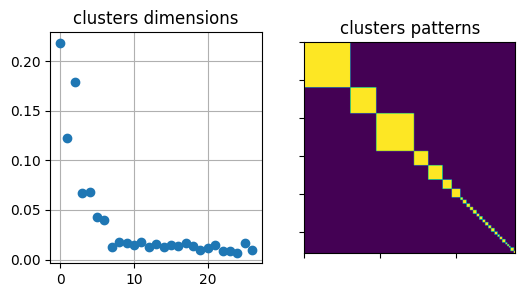

In [49]:
# overwrite topic assignment
b_topics = np.array(new_topics)
b_topics = b_topics[td2.documents]
C = sps.csr_matrix((len(b_topics),b_topics.max()+1))
for i in range(len(b_topics)):
  C[i,b_topics[i]] = 1
td2.C = C
td2.topics = b_topics
# updates topic matrices
td2.Pwc = td2.Pwd.dot(td2.C) # joint word + class probability
td2.Pcc = ((td2.C.T).dot(td2.Pdd)).dot(td2.C) # joint class + class probability
td2.pc = td2.Pcc.sum(axis=0)
# evaluate clustering metrics
td2.clustering_metrics(0)
# show clusters sizes
td2.display_clusters()
# show statistics
td2.stats

CPU times: user 78.8 ms, sys: 20.9 ms, total: 99.7 ms
Wall time: 95.8 ms


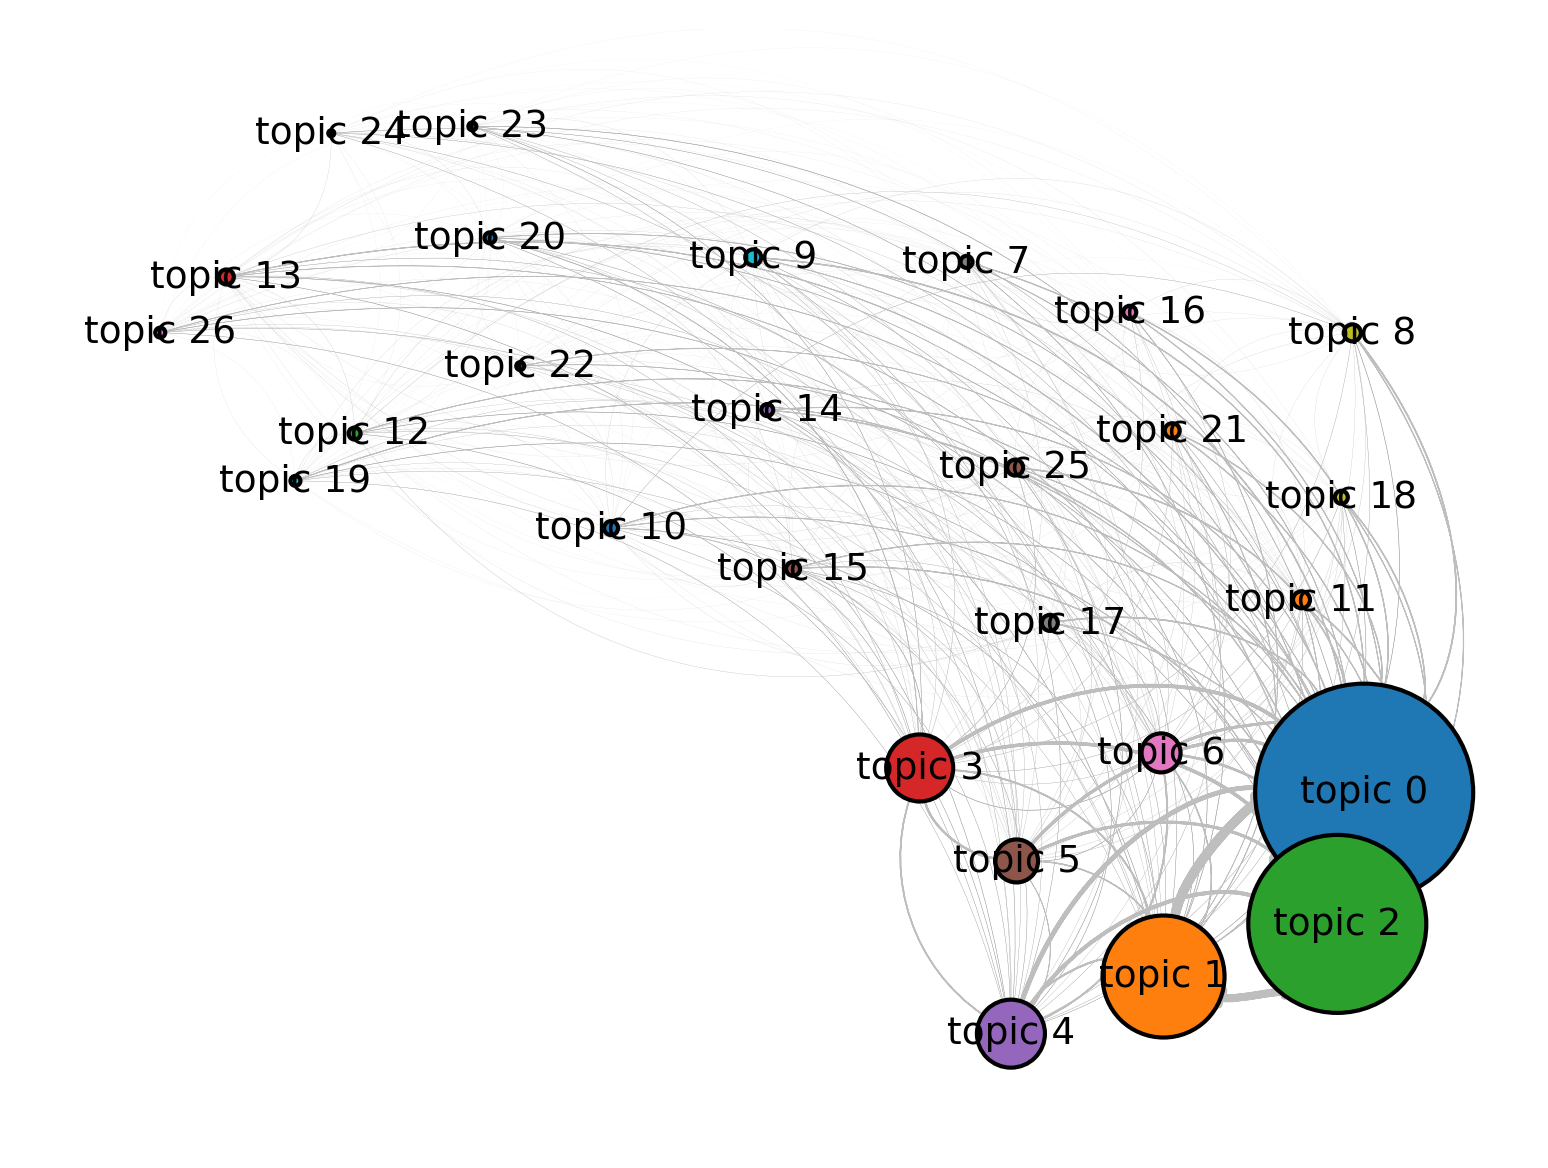

In [50]:
# nodes coordinates by umap: we use communities matrix as adjacency matrix
%time t_pos = umap.UMAP().fit_transform(td2.Pcc.toarray())
t_pos = t_pos-t_pos.mean(0) # we subtract the average values here

# topic centrality by pc
t_cen = np.array(td2.pc)[0]

# topics names
t_names = [f'topic {i}' for i in range(td2.pc.shape[1])]

# topic colors ... hard assignment
t_colors = sns.color_palette("tab10")

# build graph using Pcc
A = td2.Pcc.toarray()
np.fill_diagonal(A, 0)
G = ig.Graph.Adjacency((A>0).tolist())
At = np.tril(A, k=0)
G.es['weight'] = np.array(At[A.nonzero()])

# plot graph
fig, ax = plt.subplots(dpi=300)
ig.plot(G,
        target = ax,
        layout = t_pos,
        vertex_size = 1000*t_cen,
        vertex_color = t_colors,
        vertex_label = t_names,
        vertex_label_size = 9,
        vertex_label_dist = 0,
        edge_width = 100*np.array(G.es["weight"]),
        edge_color = 'gray',
        edge_arrow_size = 0.001
        )
